Before use download crashpy from https://gitlab.mpcdf.mpg.de/CRASH/crashpy and add to your $PYTHONPATH

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import LogNorm
from crashpy.utilities import crashMemMap

from IPython.core.interactiveshell import InteractiveShell
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

A bunch of trivial helper function the function get_maps needs

In [7]:
def get_simulation_paths(path_to_halo):
    path_in_T = os.path.join(path_to_halo, 'Input/temp_ic00.in')
    path_in_ion = os.path.join(path_to_halo, 'Input/ion.in')
    path_dens = os.path.join(path_to_halo, 'Input/dens_ic00.in')
#     path_in_T = os.path.join(path_to_halo, 'temp_ic00.in')
#     path_in_ion = os.path.join(path_to_halo, 'ion.in')
#     path_dens = os.path.join(path_to_halo, 'dens_ic00.in')
    
    path_out =  os.path.join(path_to_halo, 'Output/phys_ic00_rt05.out')
    
    return path_in_T, path_in_ion, path_dens, path_out

def get_H_map(halo):
    return np.ones(halo[1].shape)-halo[1]

def get_He_map(halo):
    return np.ones(halo[1].shape)-halo[2]-halo[3]

### get_maps(path_to_halo, props=None)

**Parameters**:
- **path_to_halo**: Just the path where the halo file is located
- **props**: What maps you want returned, default is all i.e 'T', 'xHI', 'xHII', 'xHeI', 'xHeII', 'xHeIII'

**Returns**:
- **maps**: A dictionary of dictionaries with the keywords 'in', 'out' and 'dens' corresponding to the input maps and the output after radiation transfer as well as to the gas density distribution. The first two contain a dictionary where the keyword is the map property and the value is the corresponding map in form of a 3D numpy array, the third just contains the array of the density map itself.

In [10]:
def get_maps(path_to_halo, props=None, xHI_only=False):
    if props == None:
        props = ['T', 'xHI', 'xHII', 'xHeI', 'xHeII', 'xHeIII', 'dens']
    prop_dict = {'T':0, 'xHII':1, 'xHeII':2, 'xHeIII':3}
    path_in_T, path_in_ion, path_dens, path_out = get_simulation_paths(path_to_halo) 
    
    halo_in = crashMemMap(path_in_T, 'all')
    halo_in.extend(crashMemMap(path_in_ion, 'all'))
    halo_dens = crashMemMap(path_dens, 'all')
    halo_out = crashMemMap(path_out, 'all')
    
    maps = {}
    maps['in'] = {}
    maps['out'] = {}
    for prop in props:
        if prop in prop_dict:
            maps['in'][prop] = halo_in[prop_dict[prop]] 
            maps['out'][prop] = halo_out[prop_dict[prop]]
        elif prop == 'xHI':
            maps['in'][prop] = get_H_map(halo_in)
            maps['out'][prop] = get_H_map(halo_out)
        elif prop == 'xHeI':
            maps['in'][prop] = get_He_map(halo_in)
            maps['out'][prop] = get_He_map(halo_out)
        elif prop == 'dens':
            maps['dens'] = halo_dens[0]
        else:
            raise ValueError(f'The property {prop} does not exist.')
    if xHI_only:
        HI_in = (maps['in']['xHI']*maps['dens']).sum()/maps['dens'].sum()
        HI_out = (maps['out']['xHI']*maps['dens']).sum()/maps['dens'].sum()
        return HI_in, HI_out
    else:
        return maps

### Example:

In [5]:
plt.rcParams["figure.figsize"] = (10,10)

In [11]:
xHI_in, xHI_out = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/z3/run/L35n2160TNG/sn025/g863', xHI_only=True)
#maps_dust = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/fid2/input/L35n2160TNG/sn013/g649')

In [12]:
print(xHI_in)
print(xHI_out)

0.30606949435704806
0.19795933718643866


In [32]:
maps_1_5 = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/test/input/L35n270TNG/sn008/g1')
maps_1 = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/test2/input/L35n270TNG/sn008/g1')

In [23]:
maps_649['in']['T'].max()
maps_649['in']['xHI'].mean()
maps_649['in']['T'].min()
maps_649['out']['T'].max()
maps_649['out']['xHI'].mean()
maps_649['out']['T'].min()

1618210.9

0.2238075429136358

999.99963

1618210.9

0.08402899906408397

999.99976

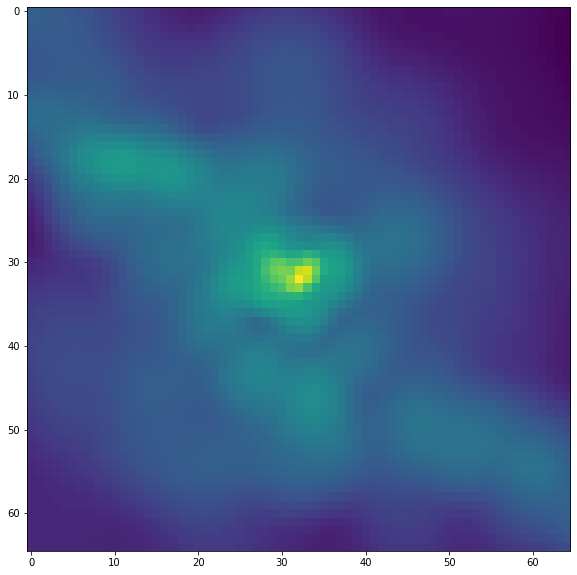

In [39]:
plt.imshow(maps_1_5['dens'][32,...], norm = LogNorm());

In [38]:
maps_1['dens'][23,...].shape
maps_1_5['dens'][32,...].shape

(44, 44)

(65, 65)

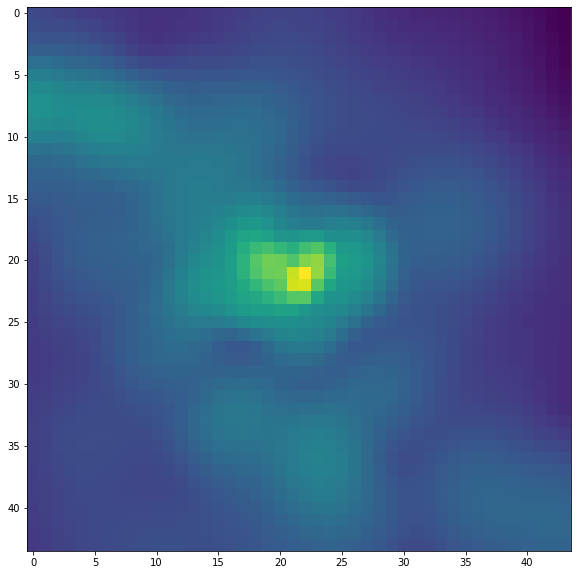

In [40]:
plt.imshow(maps_1['dens'][22,...], norm = LogNorm());

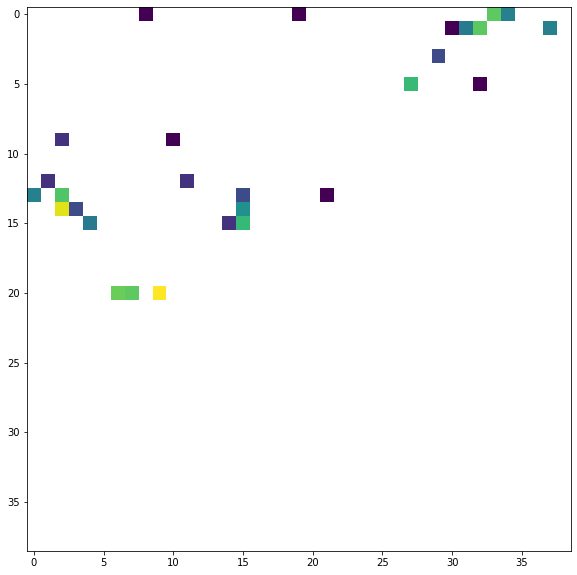

In [48]:
plt.imshow(maps_no_dust['out']['xHI'][15,...]-maps_dust['out']['xHI'][15,...], norm = LogNorm());

In [47]:
(maps_no_dust['out']['xHI']-maps_dust['out']['xHI']==0).all()

False